In [ ]:
# Update Notes by Ertugrul:
# - FocalLoss
# - Objective metric
# - data_collator 
# - Hyperparameter seach
# - Deterministic

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torch
import torch.nn as nn


import datasets
from datasets import load_dataset, load_metric
from sklearn.metrics import classification_report, f1_score
from scipy.special import expit as sigmoid

import optuna
import random

from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer


os.environ["WANDB_DISABLED"] = "true"
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

In [2]:
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state


random_state = set_seed(42)
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [3]:
intent = datasets.load_dataset("deprem-private/intent-v13")

Using custom data configuration deprem-private--intent-v13-2cc636b800f876bf
Found cached dataset json (C:/Users/dmg_e/.cache/huggingface/datasets/deprem-private___json/deprem-private--intent-v13-2cc636b800f876bf/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
df_train = pd.DataFrame().from_records(list(intent["train"]))
# df_val = pd.DataFrame().from_records(list(intent["validation"]))
df_test = pd.DataFrame().from_records(list(intent["test"]))

In [ ]:
# from ast import literal_eval
# import itertools

# a=df_train.label.apply(lambda x: literal_eval(str(x))).tolist()
# st = set(list(itertools.chain.from_iterable(a)))

In [ ]:
# name2ix = {k: v for v,k in enumerate(st)}
# ix2name = {v: k for k, v in name2ix.items()}


In [15]:
ix2name = {0: 'Lojistik',
 1: 'Elektrik Kaynagi',
 2: 'Arama Ekipmani',
 3: 'Cenaze',
 4: 'Giysi',
 5: 'Enkaz Kaldirma',
 6: 'Isinma',
 7: 'Barınma',
 8: 'Tuvalet',
 9: 'Su',
 10: 'Yemek',
 11: 'Saglik',
 12: 'Alakasiz'}

name2ix = {v: k for k, v in ix2name.items()}
labels = name2ix.keys()

In [16]:
ix2name

{0: 'Lojistik',
 1: 'Elektrik Kaynagi',
 2: 'Arama Ekipmani',
 3: 'Cenaze',
 4: 'Giysi',
 5: 'Enkaz Kaldirma',
 6: 'Isinma',
 7: 'Barınma',
 8: 'Tuvalet',
 9: 'Su',
 10: 'Yemek',
 11: 'Saglik',
 12: 'Alakasiz'}

In [17]:
df_train.head()

,image_url,label,label_confidence,labeler,label_creation_time
0,Kopyala yapıştır yaparak yayar mısınız lütfen ...,[Enkaz Kaldirma],[0.6666666667],system_consensus,1676305452109
1,-Antakya-Baba ve down sendromlu çocuğu enkaz a...,[Enkaz Kaldirma],[1.0],system_consensus,1676310480396
2,YAKIN ZAMANDA SES‼️Cebrail Mahallesi Fahri Kor...,[Enkaz Kaldirma],[1.0],system_consensus,1676321565920
3,@BabalaTv ACİLL YARDIMM ÇAĞRISIDIR!!! TEYİTLİ ...,"[Giysi, Yemek, Su]","[0.6666666667, 0.6666666667, 0.6666666667]",system_consensus,1676241278029
4,@alniopulesitivt Bahçelievler mahallesi Trabzo...,[Alakasiz],[1.0],system_consensus,1676321392038


In [18]:
label_col = "label"
text_col = "image_url"

df_train = df_train[df_train[label_col].notnull()].reset_index(drop=True)
# df_val = df_val[df_val[label_col].notnull()].reset_index(drop=True)

df_test = df_test[df_test[label_col].notnull()].reset_index(drop=True)

In [19]:
df_train.loc[1, "image_url"]

'-Antakya-Baba ve down sendromlu çocuğu enkaz altındaMüberra Güngör: 05322938539ekip var ama paletli kepçe ve ışık bekleniyor müdahale edilemiyorADRES:GAZI MAH. ADNANMENDERES CAD. NO 89 SUiT GÜZELLiK MERKEZI ÜSTÜ Antakya '

In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=list(ix2name.values()))
mlb_labels = mlb.fit_transform(df_train.label.tolist())

In [21]:
mlb_labels[0]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [22]:
model_name = "dbmdz/bert-base-turkish-128k-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer, padding="max_length", max_length=100)

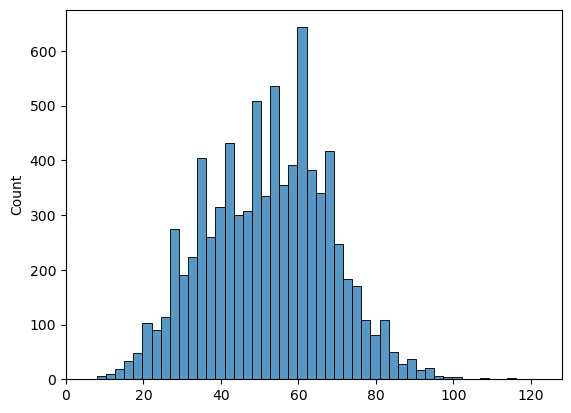

In [23]:
token_counts = []

for _, row in df_train.iterrows():

  token_count = len(tokenizer.encode(

    row["image_url"],

    max_length=128,

    truncation=True

  ))

  token_counts.append(token_count)

sns.histplot(token_counts)

plt.xlim([0, 128]);

In [24]:
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, df, num_classes=len(labels)):
        self.df = df
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text, label = row.image_url, self._encode_label(row.label)
        encoding = tokenizer(text, max_length=100, truncation=True)
        encoding = {key: torch.tensor(val, dtype=torch.int64) for key, val in encoding.items()}
        encoding["labels"] = torch.tensor(label, dtype=torch.float32)
        return dict(encoding)
    
    def _encode_label(self, input_labels):
        encoded_labels = np.zeros(self.num_classes)
        for label in input_labels:
            encoded_labels[name2ix[label]] = 1.0
        return encoded_labels

In [25]:
ds = IntentDataset(df_train)

In [26]:
def model_init():
    return (AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           label2id=name2ix,
                                                           id2label=ix2name                      
                                                          ).to('cuda'))

In [27]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

cv = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(cv.split(df_train.index.tolist(), mlb_labels)):
    df_train.loc[val_idx, 'kfold'] = int(fold)
    
df_train, df_val = df_train[df_train['kfold']!=0], df_train[df_train['kfold']==0]

print(df_train.shape)
print(df_val.shape)

(6492, 6)
(1620, 6)


In [28]:
occs = np.sum(mlb_labels[df_train.index],
       axis=0)

occ_ratios = (mlb_labels.sum() / mlb_labels.sum(axis=0))
occ_ratios /= occ_ratios.min()
occ_ratios = np.power(occ_ratios, 1/3)

class_weights = dict(zip(np.arange(mlb_labels.shape[1]), occ_ratios))
class_weights

{0: 3.017203135650159,
 1: 2.4823691788825464,
 2: 1.941736822154725,
 3: 6.172646581418988,
 4: 1.8759436445637834,
 5: 1.0,
 6: 1.75011143349181,
 7: 1.2730236191357969,
 8: 4.849237178079731,
 9: 2.4857419672410703,
 10: 1.6324480531290084,
 11: 2.0033774839735035,
 12: 1.3688883733394182}

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, pos_weight, alpha=0.1, gamma=2., reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight = pos_weight.to('cuda')

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=self.pos_weight)(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [30]:
class ImbalancedTrainer(Trainer):
    def __init__(self, class_weights,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        # You pass the class weights when instantiating the Trainer
        self.class_weights = torch.Tensor(list(class_weights.values())).cuda()

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.
        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            loss = self.label_smoother(outputs, labels)
        else:
            # We don't use .loss here since the model may return tuples instead of ModelOutput.

            # Changes start here
            # loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
            logits = outputs['logits']
            criterion = FocalLoss(self.class_weights)
            loss = criterion(logits, inputs['labels'])
            # Changes end here

        return (loss, outputs) if return_outputs else loss

In [31]:
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    clf_dict = classification_report(y_true, y_pred,
    zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
"macro f1": clf_dict["macro avg"]["f1-score"]}

In [32]:
batch_size = 32
step_size = int(np.ceil(len(df_train) / batch_size) / 4) - 1

In [33]:
HP_SEARCH = False

if HP_SEARCH:
    basic_args = TrainingArguments(
        f"turkish_multilabel_intent_{model_name.split('/')[-1]}",
        fp16=True,
        evaluation_strategy = "epoch",
        save_strategy = "no",
        #learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size*2,
        num_train_epochs=4,
        #weight_decay=0.01,
        load_best_model_at_end=False,
        metric_for_best_model="macro f1",
        # eval_steps = step_size,
        # save_steps = step_size,
        # logging_steps = step_size,
        seed = 42,
        data_seed = 42,
        dataloader_num_workers = 0,
        #lr_scheduler_type = 'linear',
        #warmup_steps=0,                # number of warmup steps for learning rate scheduler
        #weight_decay=0,               # strength of weight decay
        #save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
        full_determinism = True,
        group_by_length = True
    )

    trainer = ImbalancedTrainer(
        class_weights=class_weights, 
        model_init=model_init,
        args=basic_args,
        data_collator=data_collator,
        train_dataset=IntentDataset(df_train),
        eval_dataset=IntentDataset(df_val),
        compute_metrics=compute_metrics,
    )

    def hp_space(trial):
        return {
            # "num_train_epochs" : trial.suggest_int("num_train_epochs",2,5),
            "learning_rate" : trial.suggest_float("learning_rate", 1e-7, 1e-4),
            "weight_decay" : trial.suggest_float("weight_decay", 0.001, 0.1),
            "lr_scheduler_type" : trial.suggest_categorical("lr_scheduler_type", ["linear", "cosine"]),
            # "per_device_train_batch_size" : trial.suggest_int("per_device_train_batch_size",8,32,8),
            "warmup_steps" : trial.suggest_int("warmup_steps",0,250,10),
        }
    

    def compute_objective(metrics):
        return metrics["eval_macro f1"]

    best_run = trainer.hyperparameter_search(n_trials=15, direction="maximize", hp_space=hp_space, compute_objective=compute_objective)
    best_run

In [34]:
training_args = TrainingArguments(
    f"turkish_multilabel_intent_{model_name.split('/')[-1]}",
    fp16=True,
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate=5.1058553791201954e-05,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size*2,
    num_train_epochs=4,
    #weight_decay=0.01,
    load_best_model_at_end=True,
     metric_for_best_model="macro f1",
    eval_steps = step_size,
    save_steps = step_size,
    logging_steps = step_size,
    seed = 42,
    data_seed = 42,
    dataloader_num_workers = 0,
    lr_scheduler_type ="linear",
    warmup_steps=0,               # number of warmup steps for learning rate scheduler
    weight_decay=0.06437697487126866,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
    full_determinism = True,
    group_by_length = True
)

trainer = ImbalancedTrainer(
    class_weights=class_weights,                    
    model_init=model_init,
    args=training_args,
    data_collator=data_collator,
    train_dataset=IntentDataset(df_train),
    eval_dataset=IntentDataset(df_val),
    compute_metrics=compute_metrics,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
loading configuration file config.json from cache at C:\Users\dmg_e/.cache\huggingface\hub\models--dbmdz--bert-base-turkish-128k-uncased\snapshots\f5287aecee60f0c597c11c34341cb92d31c0e71b\config.json
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-turkish-128k-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Lojistik",
    "1": "Elektrik Kaynagi",
    "2": "Arama Ekipmani",
    "3": "Cenaze",
    "4": "Giysi",
    "5": "Enkaz Kaldirma",
    "6": "Isinma",
    "7": "Bar\u0131nma",
    "8": "Tuvalet",
    "9": "Su",
    "10": "Yemek",
    "11": "Saglik",
    "12": "Alakasiz"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id"

Step,Training Loss,Validation Loss,Micro f1,Macro f1
49,0.012600,0.008991,0.506440,0.302808
98,0.007000,0.005209,0.816014,0.629818
147,0.005000,0.004140,0.851512,0.737092
196,0.004600,0.003730,0.861579,0.764193
245,0.003400,0.003418,0.867908,0.740340
294,0.003000,0.003193,0.877217,0.777911
343,0.003100,0.003197,0.860201,0.749202
392,0.003000,0.002911,0.880481,0.779105
441,0.002100,0.002965,0.882129,0.814388
490,0.001600,0.002963,0.888193,0.820314


***** Running Evaluation *****
  Num examples = 1620
  Batch size = 64
Saving model checkpoint to turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-49
Configuration saved in turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-49\config.json
Model weights saved in turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-49\pytorch_model.bin
Deleting older checkpoint [turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-245] due to args.save_total_limit
Deleting older checkpoint [turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-294] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1620
  Batch size = 64
Saving model checkpoint to turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-98
Configuration saved in turkish_multilabel_intent_bert-base-turkish-128k-uncased\checkpoint-98\config.json
Model weights saved in turkish_multilabel_intent_bert-base-turkish-128k-uncased\

TrainOutput(global_step=812, training_loss=0.003325057638065862, metrics={'train_runtime': 293.4609, 'train_samples_per_second': 88.489, 'train_steps_per_second': 2.767, 'total_flos': 1334598181891200.0, 'train_loss': 0.003325057638065862, 'epoch': 4.0})

In [ ]:
# training_args = TrainingArguments(
#     f"turkish_multilabel_intent_{model_name.split('/')[-1]}",
#     fp16=True,
#     evaluation_strategy = "steps",
#     save_strategy = "steps",
#     learning_rate=best_run[-1]['learning_rate'],
#     per_device_train_batch_size=32,
#     per_device_eval_batch_size=batch_size*2,
#     num_train_epochs=4,
#     #weight_decay=0.01,
#     load_best_model_at_end=True,
#      metric_for_best_model="macro f1",
#     eval_steps = step_size,
#     save_steps = step_size,
#     logging_steps = step_size,
#     seed = 42,
#     data_seed = 42,
#     dataloader_num_workers = 0,
#     lr_scheduler_type = best_run[-1]['lr_scheduler_type'],
#     warmup_steps=best_run[-1]['warmup_steps'],               # number of warmup steps for learning rate scheduler
#     weight_decay=best_run[-1]['weight_decay'],               # strength of weight decay
#     save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
#     full_determinism = True,
#     group_by_length = True
# )

# trainer = ImbalancedTrainer(
#     class_weights=class_weights,
#     model_init=model_init,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=IntentDataset(df_train),
#     eval_dataset=IntentDataset(df_val),
#     compute_metrics=compute_metrics,
# )

# trainer.train()

In [35]:
preds = trainer.predict(IntentDataset(df_test))

***** Running Prediction *****
  Num examples = 2028
  Batch size = 64


In [38]:
preds = trainer.predict(IntentDataset(df_val))

***** Running Prediction *****
  Num examples = 1620
  Batch size = 64


In [39]:
best_thr = -1
best_score = 0.

for threshold in np.arange(.1, 1., .03):
    score = f1_score(preds.label_ids.astype(int), (sigmoid(preds.predictions) > threshold).astype(int), average="macro")
    if score>best_score:
        best_score = score
        best_thr = threshold

best_thr, best_score

(0.58, 0.8666219455858628)

In [40]:
print(classification_report(preds.label_ids.astype(int), (sigmoid(preds.predictions) > 0.53).astype(int), target_names=name2ix.keys(), zero_division=0))

                  precision    recall  f1-score   support

        Lojistik       0.72      0.75      0.74        28
Elektrik Kaynagi       0.81      0.80      0.80        49
  Arama Ekipmani       0.76      0.83      0.79       103
          Cenaze       1.00      0.67      0.80         3
           Giysi       0.84      0.96      0.89       114
  Enkaz Kaldirma       0.95      0.91      0.93       753
          Isinma       0.84      0.85      0.85       141
         Barınma       0.96      0.97      0.97       365
         Tuvalet       1.00      1.00      1.00         7
              Su       0.85      0.90      0.87        49
           Yemek       0.91      0.97      0.94       173
          Saglik       0.78      0.94      0.85        94
        Alakasiz       0.84      0.83      0.83       294

       micro avg       0.89      0.90      0.90      2173
       macro avg       0.87      0.87      0.87      2173
    weighted avg       0.90      0.90      0.90      2173
     samples